## **Introduction**

The initial aim of this project was to develop a system for recognizing Ukrainian characters. While a dataset containing 28,000 samples of Cyrillic handwritten characters (CoMNIST) was available, it was created in Russia and featured Soviet Union-related imagery. As a Ukrainian I have ethical considerations that made me to choose not to use this dataset. Instead I generated a small datset myself (yes, manually). This decision prompted a shift in focus to explore data augmentation techniques, applying machine learning frameworks under conditions of data scarcity. The goal became analogous to developing OCR for a rare language with minimal written samples, necessitating innovative approaches to overcome the limitations.

## **Libraries Import**

In [ ]:
import os
import random
import requests
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from skimage.filters import threshold_otsu, gaussian
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy, binary_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

import keras.backend as K
from keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam


## **Datasets Importing and Merging**

I have found a GitHub repository with a dataset, ‘Rukopys’ , which means handwriting in Ukrainian, and contains about 1000 more samples. I merged my dataset with ‘Rukopys’, and preprocessed it to ensure that the images will have the same format and will be prepared for further manipulation.

Dataset source: https://github.com/lynnporu/rukopys-dataset

In [ ]:
#connect with the google drive for data import
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
my_file_path = '/content/drive/MyDrive/cs156final/df_mine.csv'
df_mine = pd.read_csv(my_file_path)

In [ ]:
df_mine.head()

,filename,label,is_uppercase,width,height
0,/content/drive/MyDrive/cs156data/й_/Screensho...,й,False,138,110
1,/content/drive/MyDrive/cs156data/й_/Screensho...,й,False,98,86
2,/content/drive/MyDrive/cs156data/й_/Screensho...,й,False,114,96
3,/content/drive/MyDrive/cs156data/й_/Screensho...,й,False,100,98
4,/content/drive/MyDrive/cs156data/й_/Screensho...,й,False,106,102


In [ ]:
rukopys_file_path = '/content/drive/MyDrive/cs156final/rukopys-dataset.csv'
df_rukopys = pd.read_csv(rukopys_file_path)

In [ ]:
df_rukopys.tail()

,label,transliter_kmu2010,name,is_uppercase,type,is_alternate,top,bottom,left,right,height,width,filename
1076,а,a,a,True,italic,True,58,140,37,161,82,124,https://raw.githubusercontent.com/lynnporu/ruk...
1077,а,a,a,True,italic,True,47,152,38,161,105,123,https://raw.githubusercontent.com/lynnporu/ruk...
1078,а,a,a,True,italic,True,51,148,45,153,97,108,https://raw.githubusercontent.com/lynnporu/ruk...
1079,а,a,a,True,italic,True,50,149,42,157,99,115,https://raw.githubusercontent.com/lynnporu/ruk...
1080,а,a,a,True,italic,True,56,143,56,143,87,87,https://raw.githubusercontent.com/lynnporu/ruk...


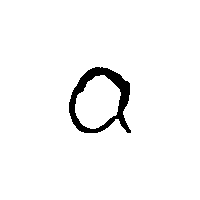

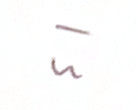

In [ ]:
def load_image(path):
    # Check if the path is a URL
    if path.startswith('http://') or path.startswith('https://'):
        # Load image from URL
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
    else:
        # Load image from local file path
        img = Image.open(path)
    return img


# For a URL
img_url = load_image(df_rukopys.loc[0, 'filename'])
# For a file path
img_file = load_image(df_mine.loc[0, 'filename'])

display(img_url) # or display(img_file) for the file path
display(img_file)


In [ ]:
df_mine['source'] = 'mine'
df_rukopys['source'] = 'rukopys'

#find the common columns excluding the 'source' column
common_columns = df_mine.columns.intersection(df_rukopys.columns).drop('source')

# Concatenate the two DataFrames, selecting only the common columns plus the new 'source' column
df = pd.concat([df_mine[common_columns.union(['source'])], df_rukopys[common_columns.union(['source'])]])

df.reset_index(drop=True, inplace=True)
df.tail()

,filename,height,is_uppercase,label,source,width
1729,https://raw.githubusercontent.com/lynnporu/ruk...,82,True,а,rukopys,124
1730,https://raw.githubusercontent.com/lynnporu/ruk...,105,True,а,rukopys,123
1731,https://raw.githubusercontent.com/lynnporu/ruk...,97,True,а,rukopys,108
1732,https://raw.githubusercontent.com/lynnporu/ruk...,99,True,а,rukopys,115
1733,https://raw.githubusercontent.com/lynnporu/ruk...,87,True,а,rukopys,87


## **Data Preprocessing**


As we can see on the visualization above the quality of the pictures produced by me is lower than the pictures from the external source. The goal of this part is to
-  pre process data to make it in the best format for further manipulation
- make sure that the format of the images is consistent cross the whole dataset


### **Grayscale Conversion and Resizing**

The input image has 4 challens: 3 channels for colour (since it is encoded in RGB) and 1 alpha channel for transparency. I will convert the images to grayscale to reduce the number of input channels from 3 (RGB) to 1. This simplification will help us to reduce the computational load for image processing (which is already for images due to the number of pixels).

## **Noise Reduction**

The images contain a lot of noice that is the result of the light and other factors. I want the model to focus on the image features ratehr than irrelevent noise. To mitigate this, I apply Gaussian Blur. It works by averaging the pixels around a target pixel within a defined kernel, where the weights of the average are determined by a Gaussian function. This operation tends to blur or smooth sharp edges and reduce detail and noise.
#### *Mathematical Perspective*
The Gaussian function in one dimension is defined as:

$$ G(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{x^2}{2\sigma^2}} $$

where:
- $x$ is the distance from the origin in the horizontal axis,
- $\sigma$ is the standard deviation of the Gaussian distribution, which controls the width of the bell curve.

For image processing, we use a 2D Gaussian function, which is the product of two 1D Gaussian functions (one for each axis, $x$ and $y$):

$$ G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}} $$

In this 2D Gaussian function:
- $x$ and $y$ are distances from the origin in the horizontal and vertical axes, respectively,
- $\sigma$ remains the standard deviation, controlling the width of the bell in both directions.

The noise reduciton parameter sigma controls the wideness of the bell curve,which allows us to control the extent of smoothing, with a higher value resulting in more significant noise reduction.

## **Normalization**

We want the pictures to have a common scale so we use normalization for that. We normalize images by dividing each pixel by the maximum pixel value in the image. This process scales the pixel values to the range [0, 1], enhancing the model's numerical stability and convergence speed.

## **Thresholding**

To further simplify the images and focus on the essential features, we apply thresholding using Otsu's method. This technique converts the grayscale images into binary (black and white) images, where the pixels are either 0 or 1, depending on whether they fall above or below the calculated threshold.

Thresholding at a level t divides the histogram into two groups:
- Pixels with intensity < t (Background)
- Pixels with intensity ≥ t (Foreground)

Otsu's method seeks to find the threshold t  that maximizes the between-class variance $\sigma_B^2(t)$, defined as:

$$ \sigma_B^2(t) = \omega_0(t) \omega_1(t) \left[ \mu_0(t) - \mu_1(t) \right]^2 $$

where:
- $ \omega_0(t) $ and $ \omega_1(t) $ are the probabilities of the two classes separated by the threshold $ t $.
- $ \mu_0(t) $ and $ \mu_1(t) $ are the class means of these two groups.

The class probabilities and means can be computed directly from the image histogram:
- $ \omega_0(t) $ and $ \omega_1(t) $ are calculated by summing the normalized histogram values up to and after the threshold $ t $, respectively.
- $ \mu_0(t) $ and $ \mu_1(t) $ are the means of the pixel intensities for each class, weighted by their probabilities.

The optimal threshold $ t^* $ is found by iterating over all possible threshold values (from 0 to 255 for an 8-bit image) and calculating $ \sigma_B^2(t) $ for each. The $ t $ that yields the maximum $ \sigma_B^2(t) $ is chosen as the threshold:

$$ t^* = \underset{t}{\mathrm{argmax}}\ \sigma_B^2(t) $$

Once the optimal threshold $ t^* $ is determined, the binary image is obtained by converting all pixels:
- Below $ t^* $ to 0 (black/background)
- Equal to or above $ t^* $ to 1 (white/foreground)

## **Resizing**

To ensure consistency in the input dimensions for our model, I resize all images to a standard size of 128x128 pixels using resize.


In [ ]:
def preprocess_image(image_path, label, noise_reduction_sigma=1, is_url=False):
    if is_url:
        # Handle GitHub URLs
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
        image = np.array(image)
    else:
        # Handle local files
        image = io.imread(image_path)


    if image.shape[-1] == 4:
        image = image[..., :3]

    # Convert to grayscale
    grayscale = rgb2gray(image)

    # Apply Gaussian Blur for noise reduction
    smoothed = gaussian(grayscale, sigma=noise_reduction_sigma)

    # Normalize the pixel values
    normalized = smoothed / np.max(smoothed)

    # Apply thresholding
    thresh = threshold_otsu(normalized)
    binary = normalized > thresh

    processed_image = resize(binary, (128, 128))

    return processed_image, label

In [ ]:
preprocessed_data = []

# set up 2 loops for preprocessing images form 2 sources

# from df_rukopys (url)
for img_url, label in zip(df_rukopys['filename'], df_rukopys['label']):
    preprocessed_data.append(preprocess_image(img_url, label, is_url=True))

# from df_mine (drive path)
for img_path, label in zip(df_mine['filename'], df_mine['label']):
    preprocessed_data.append(preprocess_image(img_path, label, is_url=False))

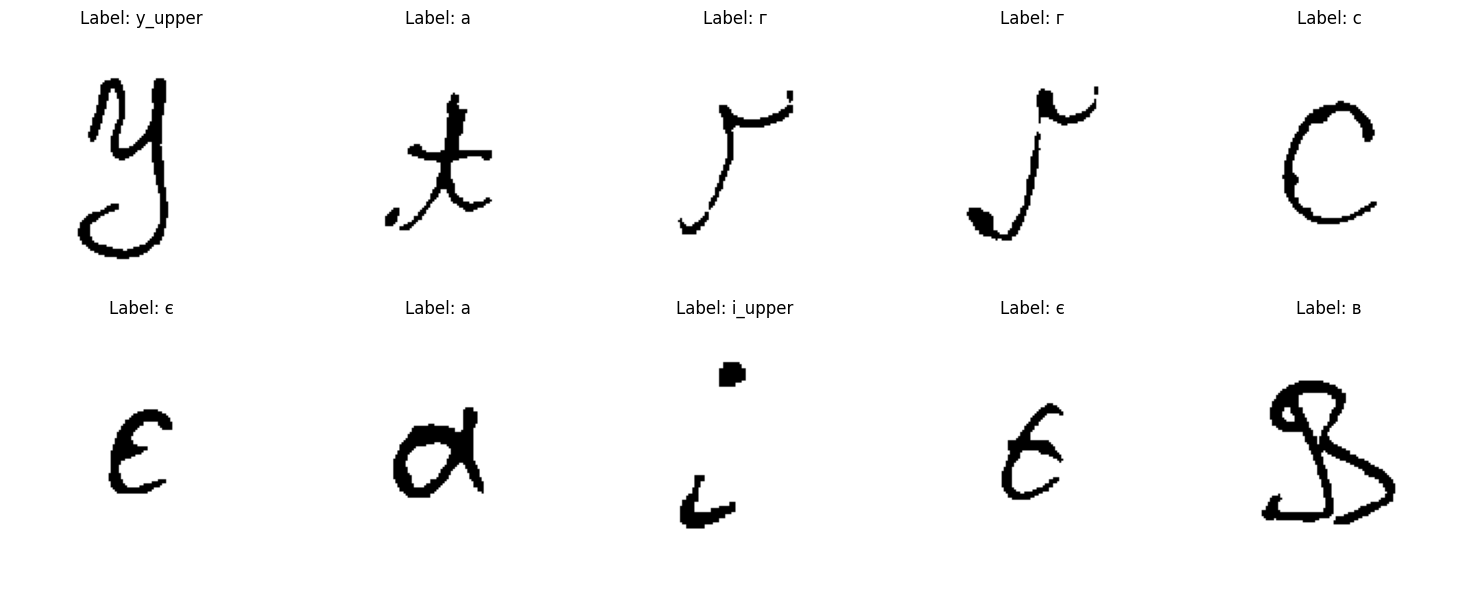

In [ ]:
def show_random_images(preprocessed_data, num_images=10):
    random_data = random.sample(preprocessed_data, num_images)

    rows = 2
    cols = num_images // rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    # Display each image in the grid
    for i, (processed_image, label) in enumerate(random_data):
        ax = axes[i]
        ax.imshow(processed_image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    # If num_images is not a multiple of rows, turn off the extra subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(preprocessed_data)


## **Exploratory Data Analysis of Preprocessed Data**

Since I am merging 2 different datasets, it is important to see category distribution to avoid potential data imbalances.
Based on Figure below we can see that the joint dataset is highly imbalanced with a greeted count of the lowercase character samples. Deleting uppercase characters will improve model performance and given the infrequent appearance of upper-case characters compared to the lower-case ones, the benefit of this action will outweigh the cost. Additionally, for some characters, there is little to no distinction between the upper and lower case, which implies that a hierarchical solution is required where the first step will be case classification and the second character classification. Since the focus of this work has shifted towards generating synthetic data, creating a hierarchical model (which again will not work due to data scarcity) is outside of the scope. I can also see that there are 2 duplications due to different keyboards, so I merged them.


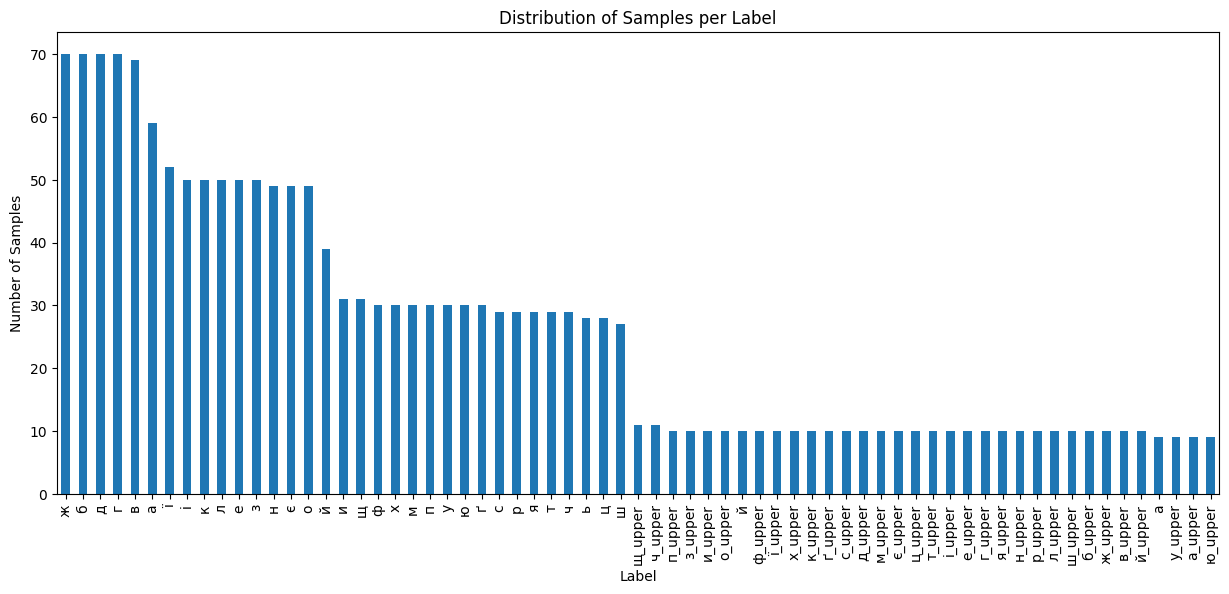

In [ ]:
preprocessed_df = pd.DataFrame(preprocessed_data, columns=['image', 'label'])
label_distribution = preprocessed_df['label'].value_counts()

plt.figure(figsize=(15,6))
label_distribution.plot(kind='bar')
plt.title('Distribution of Samples per Label')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()


In [ ]:
#get a df of lowercase chacracters
lowercase_df = preprocessed_df[~preprocessed_df['label'].str.contains("upper")]
#edit the prepeocessed data
preprocessed_data_lower = list(lowercase_df.itertuples(index=False, name=None))
#convert back to df
preprocessed_df_lower = pd.DataFrame(preprocessed_data_lower, columns=['image', 'label'])

In [ ]:
# map the labels  to merge
merge_mapping = {'й': 'й', 'a': 'а'}

# Use the 'replace' method to replace the labels in the DataFrame according to the mapping
preprocessed_df_lower['label'] = preprocessed_df_lower['label'].replace(merge_mapping)

final_label_distribution = preprocessed_df_lower['label'].value_counts()

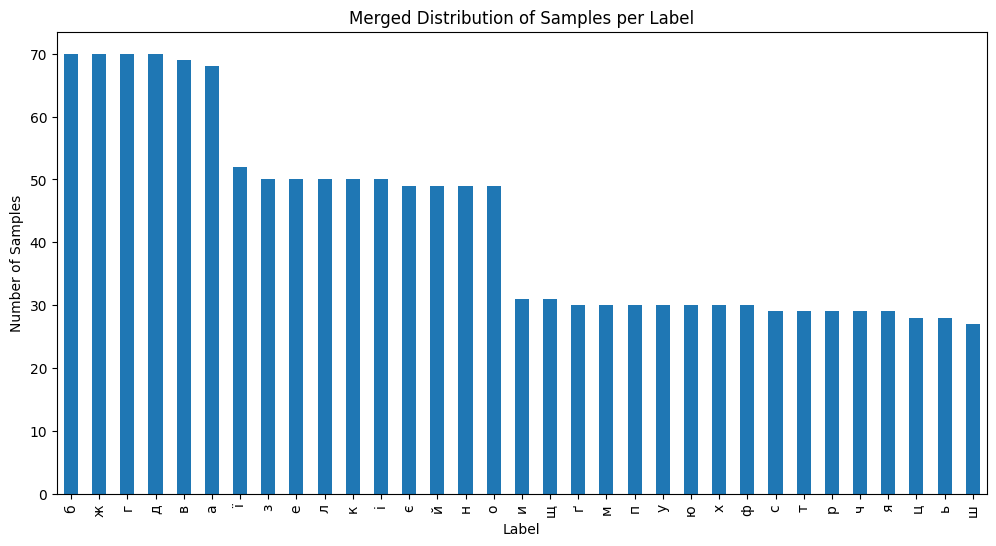

In [ ]:
final_label_distribution.plot(kind='bar', figsize=(12, 6))
plt.title('Merged Distribution of Samples per Label')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
#convert final data to df
preprocessed_data_lower = list(preprocessed_df_lower.itertuples(index=False, name=None))

## **Data Splitting**

I split the dataset into three subsets:

**Training Set**: This set has a majority of the data and is used to train the model. I allocate about 70% of the dataset to the training set which is aligned with the industry standarts.

**Validation Set**: I reserve a smaller portion of the data for validation purposes. The validation set helps in tuning hyperparameters and monitoring the model's performance during training. I allocate approximately 15% of the dataset to the validation set which is aligned with the industry standarts.

**Test Set**: The test set is kept separate from the training and validation sets and is used to evaluate the model's performance on unseen data. I allocate approximately 15% of the dataset to the test set which is aligned with the industry standarts..


In [ ]:
X = [img for img, _ in preprocessed_data_lower]
y = [label for _, label in preprocessed_data_lower]

#data -> training set + a temporaty set representing a combination of validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#temporary set -> validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {len(X_train)} images")
print(f"Validation set size: {len(X_val)} images")
print(f"Test set size: {len(X_test)} images")

Training set size: 990 images
Validation set size: 212 images
Test set size: 213 images


## **Data Augmentation**

###ImageDataGenerator:

ImageDataGenerator applies various transformations to the original images, such as rotation, shifting, zooming, rescaling, shearing. These transformations mimic real-world variations that might be encountered in the data, making the model more robust and capable of handling different scenarios.

I am performing data augmentation after splitting the data into training testing and validation datasets. This ensures that the same original image does not appear in multiple sets, which could introduce data leakage and bias the model evaluation. Also, I will apply data augmentation techniques only to the training set. This expands the diversity of the training data while leaving the validation and test sets untouched. Each of the parameters in ImageDataGenerator applies to each image during augmentation. As a result, for each image in the original training dataset a corresponding augmented image is generated. By combining these augmented images with the original training dataset, we effectively double the training sample size, resulting in approximately 1980 training samples.

In [ ]:
X_train_expanded = np.expand_dims(X_train, axis=-1)

In [ ]:
#data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

#apply data augmentation only to the training set
augmented_train_data = datagen.flow(X_train_expanded, y_train, batch_size=len(X_train_expanded))
#retrieve augmented data and labels
X_train_augmented, y_train_augmented = next(augmented_train_data)
print(f"Number of augmented training images generated: {len(X_train_augmented)}")

Number of augmented training images generated: 990


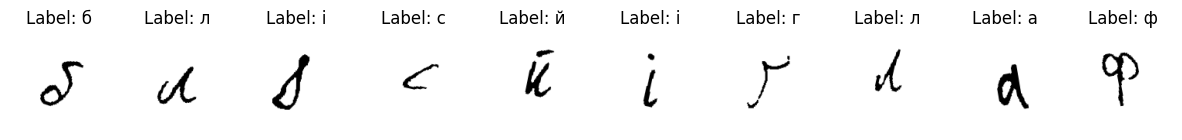

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    #get batch of augmented images and labels
    batch, labels_batch = next(augmented_train_data)
    #select the first image from the batch and remove the channel dimension for plotting
    image = batch[0].reshape(batch[0].shape[0], batch[0].shape[1])
    label = labels_batch[0]

    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f'Label: {label}')
    ax[i].axis('off')

In [ ]:
X_train_combined = np.concatenate([X_train_expanded, X_train_augmented])
y_train_combined = np.concatenate([y_train, y_train_augmented])

#  shuffle the dataset to ensure randomness
permutation = np.random.permutation(len(X_train_combined))
X_train_combined = X_train_combined[permutation]
y_train_combined = y_train_combined[permutation]

print(f"Size of the combined training dataset: {len(X_train_combined)}")

Size of the combined training dataset: 1980


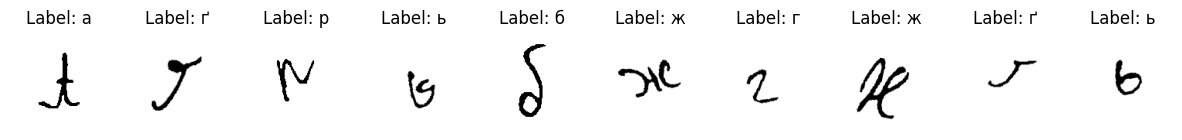

In [ ]:
def visualize_dataset(X, y, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    indices = np.random.choice(len(X), num_samples, replace=False)
    for i, ax in enumerate(axes):
        idx = indices[i]
        ax.imshow(X[idx].squeeze(), cmap='gray')
        ax.set_title(f'Label: {y[idx]}')
        ax.axis('off')
    plt.show()

visualize_dataset(X_train_combined, y_train_combined)


## **PCA**



Principal Component Analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component, in turn, has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a principal component) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

### 1. Standardize the Data

Given a dataset $X$ of dimensions $(n, d)$ where $n$ is the number of observations and $d$ is the number of variables, the first step in PCA is to standardize the data. Standardization ensures that each variable contributes equally to the analysis by giving them all mean of 0 and variance of 1:

$$ Z = \frac{X - \mu}{\sigma} $$

Where:
- $X$ is the original dataset,
- $\mu$ is the mean of each variable,
- $\sigma$ is the standard deviation of each variable,
- $Z$ is the standardized dataset.

### 2. Compute the Covariance Matrix

The covariance matrix, $\Sigma$, is computed from the standardized data, $Z$. The covariance of two variables measures how much the variables change together. If the variables are independent, the covariance is zero. The covariance matrix is a $d \times d$ symmetric matrix with the variances of the variables on the diagonal and covariances on the off-diagonal:

$$ \Sigma = \frac{1}{n-1} Z^T Z $$

### 3. Calculate Eigenvalues and Eigenvectors

The next step involves calculating the eigenvalues and eigenvectors of the covariance matrix. The eigenvectors of the covariance matrix represent the directions of the maximum variance (principal components), and the eigenvalues represent the magnitude of the variance along each eigenvector. The eigenvalue equation can be represented as:

$$ \Sigma v = \lambda v $$

Where:
- $\Sigma$ is the covariance matrix,
- $v$ are the eigenvectors,
- $\lambda$ are the eigenvalues.

The eigenvectors are computed such that they are normalized to unit length.

### 4. Sort Eigenvalues and Eigenvectors

Sort the eigenvalues in descending order and rank the corresponding eigenvectors. This step ensures that the first eigenvector corresponds to the highest eigenvalue and thus explains the most variance within the dataset.

### 5. Project Data Onto Lower-Dimensional Space

Select the first $k$ eigenvectors, which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace ($k \leq d$). Project the original standardized data onto this subspace to obtain the reduced-dimensionality data:

$$ Y = Zv_k $$

Where:
- $Z$ is the standardized original data,
- $v_k$ is the matrix of selected eigenvectors,
- $Y$ is the transformed data in the reduced-dimensional space.

### Output

The output of PCA is the transformed dataset $Y$ of dimensions $(n, k)$, where $n$ is the number of observations, and $k$ is the reduced number of dimensions. This dataset represents the original data projected onto the first $k$ principal components.





In [ ]:
# Flatten each image in the dataset
X_train_flattened = X_train_combined.reshape(X_train_combined.shape[0], -1)

In [ ]:
n_components = 200
pca = PCA(n_components=n_components)
pca_images = pca.fit_transform(X_train_flattened)

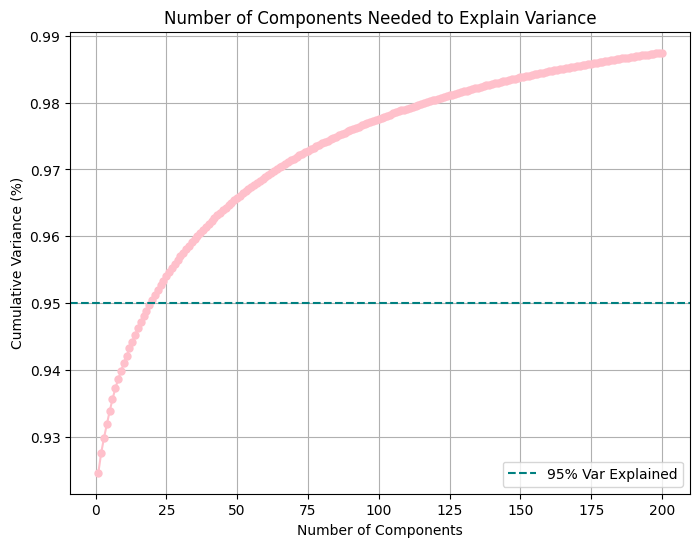

In [ ]:
# Plot number of components vs. explained variance
# code adapted form class session 14: PCA
plt.figure(figsize=(8,6))

components = np.arange(1, n_components+ 1, step=1)
var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, var, color='pink', marker='o', linestyle='-', markersize=5)
plt.axhline(y=0.95, color='teal', linestyle='--', label='95% Var Explained')

plt.title('Number of Components Needed to Explain Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

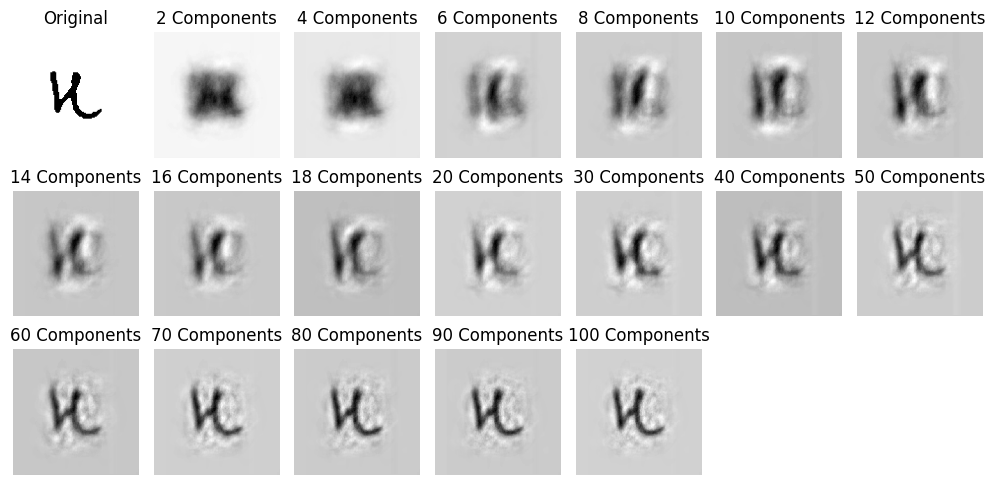

In [ ]:
original_image = X_train_flattened[0]  # Choose the first image for demonstration

# Number of components to visualize reconstructions for
component_numbers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100]

n_rows = 3
n_cols = 7

# Plot original image
plt.figure(figsize=(10, 5))
plt.subplot(n_rows, n_cols, 1)
plt.imshow(original_image.reshape(128, 128), cmap='gray')  # Reshape back to original dimensions
plt.title('Original')
plt.axis('off')

# Reconstruct and plot the image using different numbers of PCA components
for i, n_components in enumerate(component_numbers, start=2):
    pca = PCA(n_components=n_components)
    pca.fit(X_train_flattened)
    transformed_image = pca.transform(X_train_flattened[None, 0])  # Transform the chosen image
    reconstructed_image = pca.inverse_transform(transformed_image)  # Reconstruct the image

    # Plot reconstructed image
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(reconstructed_image.reshape(128, 128), cmap='gray')  # Reshape back to original dimensions
    plt.title(f'{n_components} Components')
    plt.axis('off')

plt.tight_layout()
plt.show()

We can see that 25 components will be enough to capture most of the variance in the data. However, when we look at the visualization of the PCA with different numbers of components we can see that in order to get a better quality we need to set the number of components to 100.

In [ ]:
# Flatten the training, validation, and test sets
X_val_flattened = np.array(X_val).reshape(len(X_val), -1)
X_test_flattened = np.array(X_test).reshape(len(X_test), -1)

# Initialize PCA with 100 components
pca = PCA(n_components = 100)

# Fit PCA on the flattened training data
pca.fit(X_train_flattened)

# Transform the flattened training, validation, and test data
X_train_pca = pca.transform(X_train_flattened)
X_val_pca = pca.transform(X_val_flattened)
X_test_pca = pca.transform(X_test_flattened)

print(f"Shape of X_train_pca: {X_train_pca.shape}")
print(f"Shape of X_val_pca: {X_val_pca.shape}")
print(f"Shape of X_test_pca: {X_test_pca.shape}")

Shape of X_train_pca: (1980, 100)
Shape of X_val_pca: (212, 100)
Shape of X_test_pca: (213, 100)


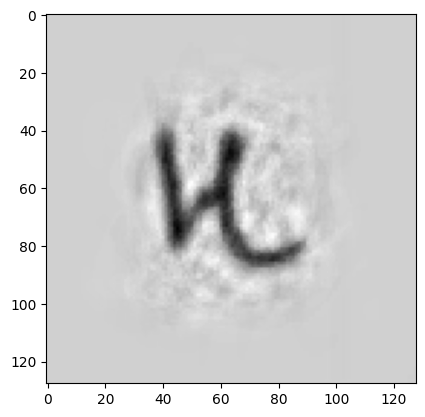

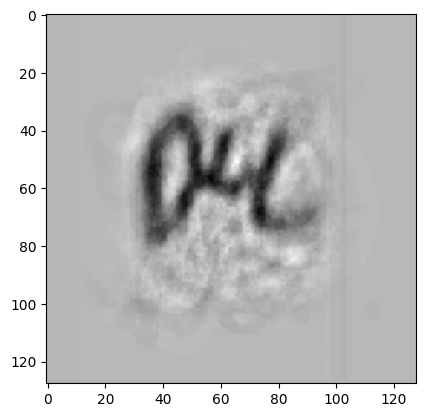

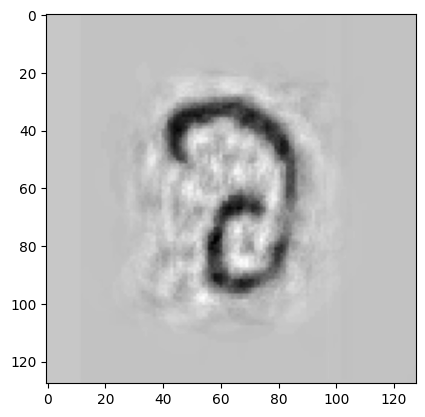

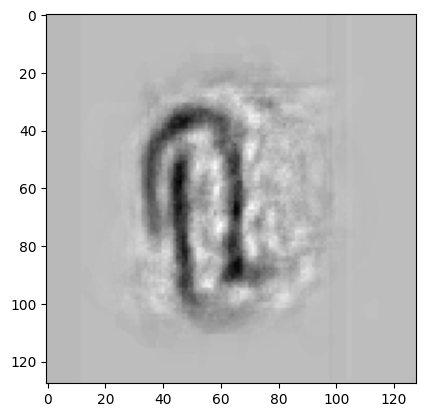

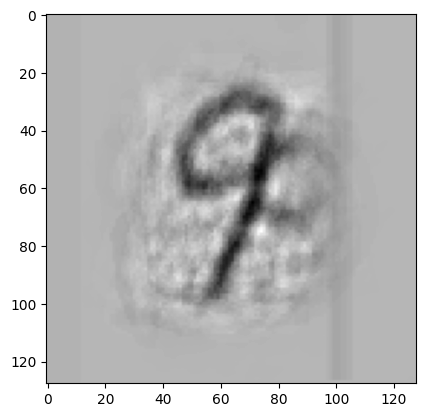

In [ ]:
#visualize the transformed dataset
transformed = pca.inverse_transform(X_train_pca)
for i in transformed[:5]:
  plt.imshow(i.reshape(128, 128), cmap='gray')
  plt.show()

## **TSNE**

After reducing the dimensionality with PCA to a more manageable level (100 components), I then apply t-SNE for further reduction (to 2 dimensions) for visualization purposes.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction technique well-suited for visualizing high-dimensional data in low-dimensional spaces, typically 2D. t-SNE works by calculating similarities between points in the high-dimensional space and attempting to reproduce those similarities in the low-dimensional space. It adjusts the positions of points in the low-dimensional space to minimize the discrepancy between these two sets of similarities. The use of the Student-t distribution in the low-dimensional space helps to overcome the crowding problem and enables t-SNE to create maps that reveal the data's underlying structure, including clusters and outliers.

**t-SNE involves two main stages**:

1. Computing Pairwise Similarity Probabilities in the High-Dimensional Space
2. Computing Pairwise Similarity Probabilities in the Low-Dimensional Space and Minimizing the Kullback-Leibler Divergence between the two

#### Stage 1: High-Dimensional Similarity Probabilities

For each data point $x_i$ in the original high-dimensional space, t-SNE computes the conditional probability $p_{j|i}$ that represents the similarity of datapoint $x_j$ to datapoint $x_i$:

$$p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}$$

Here, $||x_i - x_j||^2$ is the squared Euclidean distance between $x_i$ and $x_j$, and $\sigma_i$ is the variance of the Gaussian centered on datapoint $x_i$. The variance $\sigma_i$ is chosen such that the conditional distribution over neighbors has a fixed perplexity, a user-specified measure of the effective number of local neighbors, typically between 5 and 50.

The joint probabilities $p_{ij}$ are then defined as the symmetrized versions of the conditional probabilities:

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$$

where $N$ is the number of data points.

#### Stage 2: Low-Dimensional Similarity Probabilities and Kullback-Leibler Divergence Minimization

In the low-dimensional space, t-SNE defines a joint probability distribution $q_{ij}$ over pairs of points based on their distances in the embedding space:

$$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}$$

Unlike in the high-dimensional space, a Student-t distribution (with one degree of freedom, equivalent to the Cauchy distribution) is used in the low-dimensional space to alleviate the "crowding problem" and allow clusters to form more distinctly.

t-SNE minimizes the Kullback-Leibler (KL) divergence between the two distributions $P$ and $Q$:

$$C = KL(P || Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

The minimization of KL divergence is usually achieved using gradient descent. The gradient of KL divergence with respect to the low-dimensional points $y_i$ is:

$$\frac{\delta C}{\delta y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$$



### **T-SNE pseudo algorithm**

1. **Input**: High-dimensional data $X$, target dimensionality $d$ (typically $d=2$ or $d=3$ for visualization), perplexity `Perp`, and number of iterations $N_{iter}$.

2. **Output**: Low-dimensional representation $Y$ of the data $X$.

**Algorithm Steps**:

- **Step 1**: Compute pairwise affinities $p_{j|i}$ in the high-dimensional space, using a Gaussian distribution centered at each point $x_i$ with variance $\sigma_i^2$. The variance is chosen such that the perplexity of the conditional distribution equals the user-specified perplexity `Perp`.

- **Step 2**: Compute the symmetrized affinities $p_{ij}$ by averaging $p_{j|i}$ and $p_{i|j}$ and then normalizing.

- **Step 3**: Initialize the low-dimensional representation $Y$ randomly.

- **Step 4**: Compute pairwise affinities $q_{ij}$ in the low-dimensional space using a Student-t distribution with one degree of freedom.

- **Step 5**: Minimize the Kullback-Leibler divergence between the high-dimensional affinities $p_{ij}$ and the low-dimensional affinities $q_{ij}$ using gradient descent. The gradient of the Kullback-Leibler divergence with respect to each point $y_i$ in the low-dimensional map is used to update the positions of the points in the map.

- **Step 6**: Repeat Step 5 for $N_{iter}$ iterations, or until convergence.

The perplexity parameter `Perp` controls the balance between preserving local and global structures and typically is set in the range of 5 to 50. The exact number of iterations $N_{iter}$ needed depends on the specific dataset and the desired stability of the resulting embedding.



In [ ]:
n_components_tsne = 2
tsne = TSNE(n_components=n_components_tsne, perplexity=30.0, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(X_train_pca)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_combined)

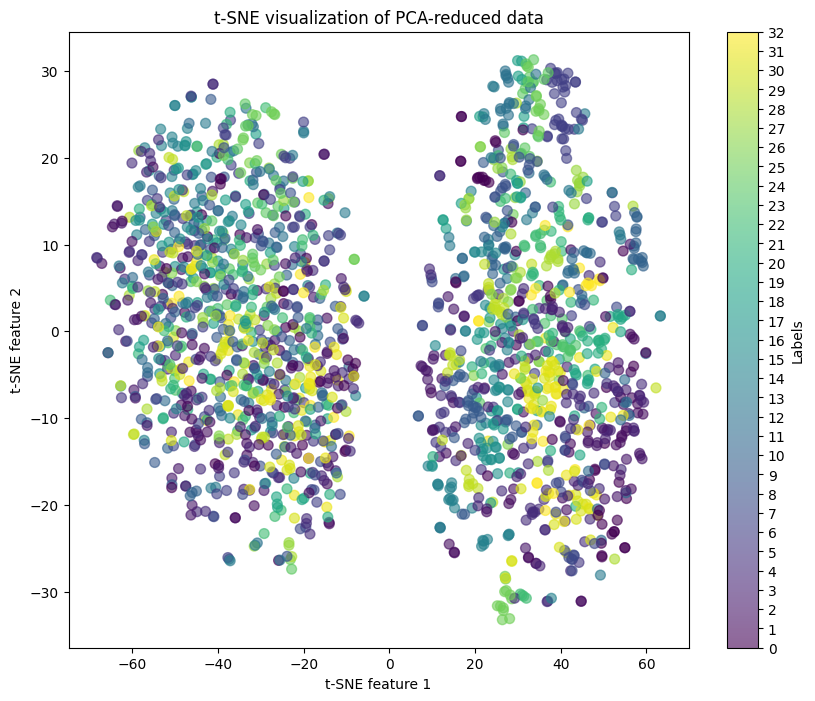

In [ ]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(X_train_pca)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_train_encoded, cmap='viridis', s=50, alpha=0.6)
plt.colorbar(ticks=range(len(np.unique(y_train_encoded))), label='Labels')
plt.title('t-SNE visualization of PCA-reduced data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


## **Conditional variational autoencoders (CVAE)**

 Conditional Variational Autoencoder (CVAE) is a generative model that learns to approximate the data distribution of its input data and can generate new data points conditioned on certain attributes.

 The model takes two inputs: inputs, which is the feature representation of the data, and labels, which is a one-hot encoded vector of class labels.

### Encoder

Encoder functions to approximate the true posterior distribution $p(z \mid x, y)$, where $x$ represents the input data, $y$ represents conditional information such as class labels, and $z$ represents the latent variables.

The encoder, parameterized by $\theta$, maps an input $x$ and a condition $y$ to two vectors: $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$, which parameterize a Gaussian distribution in the latent space. This results in a conditional probability distribution $q_{\theta}(z \mid x, y)$.

Given an input $x \in \mathbb{R}^{D}$ with original dimensionality $D$ and a one-hot encoded label $y \in \mathbb{R}^{C}$ for $C$ classes, the encoder concatenates these to form a combined input:

$$
x_{combined} = \text{Concatenate}(x, y)
$$

This combined input is passed through dense layers with ReLU activation functions. The ReLU activation function is defined as:

$$
\text{ReLU}(z) = \max(0, z)
$$

Each dense layer transforms the input as follows:

$$
h = \text{ReLU}(\mathbf{W}_{\theta} \cdot x_{combined} + \mathbf{b}_{\theta})
$$

Here, $\mathbf{W}_{\theta}$ and $\mathbf{b}_{\theta}$ denote the weights and biases of the dense layers, with $\theta$ representing the learned parameters.

To promote generalization and avoid overfitting, L1 and L2 regularization techniques are employed, adding terms proportional to the absolute and square values of the weights:

$$
L1_{reg} = \lambda_{1} \sum_{i} |w_{i}|
$$

$$
L2_{reg} = \lambda_{2} \sum_{i} w_{i}^2
$$

where $\lambda_{1}$ and $\lambda_{2}$ are regularization coefficients, and $w_{i}$ are individual weights.

The encoder's output consists of two vectors $\boldsymbol{\mu} \in \mathbb{R}^{M}$ and $\boldsymbol{\Sigma} \in \mathbb{R}^{M}$ for a latent dimension $M$. These vectors represent the mean and log-variance of the Gaussian distribution:

$$
\boldsymbol{\mu} = \mathbf{W}_{\mu}h + \mathbf{b}_{\mu}
$$

$$
\log(\boldsymbol{\Sigma}) = \mathbf{W}_{\Sigma}h + \mathbf{b}_{\Sigma}
$$

To backpropagate through the random sampling process, the reparameterization trick is applied. An auxiliary variable $\boldsymbol{\epsilon}$ is drawn from a standard normal distribution $\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$, and the latent variable $\mathbf{z}$ is computed as:

$$
\mathbf{z} = \boldsymbol{\mu} + \exp\left(\frac{1}{2} \log(\boldsymbol{\Sigma})\right) \odot \boldsymbol{\epsilon}
$$

where $\odot$ denotes element-wise multiplication. This reparameterization enables the gradient of the loss function to propagate back through $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$, retaining the stochastic nature of $\mathbf{z}$.

In this way, the encoder compresses the input data into a compact latent representation, while ensuring that small changes in the input and condition lead to smooth variations in the latent space. This property is essential for the generation of meaningful new samples from the latent space in a controlled manner, conditioned on specific attributes.

### Sampling Function

The sampling function enables the model to perform variational inference while remaining differentiable, a necessity for gradient-based optimization methods such as backpropagation. This function implements the reparameterization trick, allowing the encoder to learn a distribution over the latent space.

Given the outputs of the encoder, $ \mu $ (z_mean) and $ \log(\sigma^2) $ (z_log_sigma), the goal is to sample a latent vector $ z $ from the approximate posterior distribution $ q_{\theta}(z|x,y) $ which is assumed to be Gaussian. Directly sampling $ z $ from this distribution would prevent the gradient of the loss function with respect to the parameters of the encoder from being computed because the sampling operation is nondeterministic. The reparameterization trick circumvents this issue by expressing $ z $ as a deterministic function of $ \mu $, $ \sigma $, and an auxiliary random variable $ \epsilon $, which allows the gradient to flow through the network during backpropagation.

The reparameterization trick is mathematically represented as:

$$ z = \mu + \sigma \odot \epsilon $$

where:

- $ \mu $ is z_mean, the mean of the Gaussian distribution learned by the encoder.
- $ \sigma $ is the exponentiation of z_log_sigma, representing the standard deviation of the Gaussian distribution.
- $ \epsilon $ is a random vector sampled from a standard normal distribution $ \mathcal{N}(0,I) $.
- $ \odot $ denotes element-wise multiplication.

This reparameterization allows us to sample $ z $ in a way that is differentiable with respect to $ \mu $ and $ \sigma $, enabling the use of gradient descent for training the VAE.

The sampling function's implementation typically involves generating $ \epsilon $ using a suitable random number generator, scaling $ \epsilon $ by $ \sigma $, and then adding $ \mu $ to produce $ z $. This process ensures that $ z $ has the desired distribution $ q_{\theta}(z|x,y) = \mathcal{N}(z; \mu, \sigma^2) $ while also allowing gradients to propagate through the random sampling process.

### Decoder

The Decoder maps a point $z$ from the latent space back to the original data space. The latent space vector $z$ is assumed to be sampled from a probability distribution that has been learned during the training of the encoder.

Given a sampled latent vector $z \in \mathbb{R}^{l}$, where $l$ is the dimensionality of the latent space, and a one-hot encoded vector of labels $c \in \{0,1\}^{n}$, where $n$ is the number of classes, the decoder seeks to reconstruct the original data by performing the following steps:

1. **Concatenation**:
   The sampled latent vector $z$ and the one-hot encoded label $c$ are concatenated to form a combined vector.
   $$
   z_c = [z; c]
   $$
   Here, $[;]$ denotes the concatenation operation, and the resulting vector $z_c \in \mathbb{R}^{l + n}$ serves as the input to the decoder network.

2. **Decoding**:
   The combined vector $z_c$ is then passed through several layers of the decoder network, which typically consist of dense layers with non-linear activation functions. Each layer in the decoder network can be represented as:
   $$
   h_{i+1} = \phi(W_i h_i + b_i)
   $$
   where $h_i$ is the output of the $i$-th layer (with $h_0 = z_c$ being the input to the first layer), $W_i$ and $b_i$ are the weights and biases of the $i$-th layer, $\phi(\cdot)$ is a non-linear activation function, such as the ReLU function, and $h_{i+1}$ is the input to the next layer.

3. **Reconstruction**:
   The final layer of the decoder network aims to reconstruct the original data. The output of this layer is a vector $\hat{x} \in \mathbb{R}^{d}$, where $d$ is the dimensionality of the original input data. The output is  passed through a sigmoid activation function to ensure that the reconstructed data $\hat{x}$ has values between 0 and 1, since the original data was normalized in this range.
   $$
   \hat{x} = \sigma(W_{dec} h_{final} + b_{dec})
   $$
   where $W_{dec}$ and $b_{dec}$ are the weights and biases of the final layer, $\sigma(\cdot)$ is the sigmoid function, and $h_{final}$ is the output of the last hidden layer in the decoder network.


The reconstructed data $\hat{x}$ is then compared to the original input data $x$ to compute the reconstruction loss, which is a part of the overall loss function optimized during training.

The reconstruction loss is computed using binary cross-entropy:

$$
L_{\text{recon}}(x, \hat{x}) = - \sum_{i=1}^{D} \left[ x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i) \right]
$$

where $D$ is the dimensionality of the input data, $x_i$ represents the $i$-th element of the original input vector $x$, and $\hat{x}_i$ is the $i$-th element of the reconstructed vector $\hat{x}$.


The KL divergence, $KL(q(z|x) \, || \, p(z))$, acts as a regularization term, encouraging the latent space distribution learned by the encoder, $q(z|x)$, to be similar to some prior distribution, a standard normal distribution, $p(z)$. The KL divergence between the encoder's distribution and the prior is given by:

$$
KL(q(z|x) \, || \, p(z)) = - \frac{1}{2} \sum_{j=1}^{L} \left(1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2\right)
$$

where $L$ is the dimensionality of the latent space, $\mu_j$ and $\sigma_j^2$ are the $j$-th elements of the mean and variance vectors output by the encoder, respectively.

The overall loss function for the CVAE, $L_{\text{CVAE}}$, is the sum of the reconstruction loss and the KL divergence, which we seek to minimize during training:

$$
L_{\text{CVAE}}(x, \hat{x}, z) = L_{\text{recon}}(x, \hat{x}) + KL(q(z|x) \, || \, p(z))
$$

In this formulation, $z$ represents a latent vector sampled from the distribution $q(z|x)$, which is parameterized by $\mu$ and $\sigma$. The combined loss function ensures that the model not only generates data that closely resembles the input data but also learns a meaningful and well-structured latent space representation.

## **Pseudo Algorithm**


## Inputs

- Input data vector, $\mathbf{x} \in \mathbb{R}^{D}$
- One-hot encoded label vector, $\mathbf{c} \in \{0,1\}^{C}$

## Encoder Network

1. Encode labels using a dense layer:
   $$\mathbf{c}_{encoded} = ReLU(Dense_{I}(\mathbf{c}))$$

2. Concatenate encoded labels with input data:
   $$\mathbf{z}_{concat} = Concatenate(\mathbf{x}, \mathbf{c}_{encoded})$$

3. Pass concatenated vector through dense layers with regularization, followed by batch normalization and dropout:
   $$\mathbf{z}_{intermediate} = Dropout(BatchNormalization(ReLU(Dense_{I}(\mathbf{z}_{concat},\, \text{regularization}))))$$
   $$\mathbf{z}_{intermediate2} = Dropout(BatchNormalization(ReLU(Dense_{\frac{I}{2}}(\mathbf{z}_{intermediate},\, \text{regularization}))))$$

4. Compute parameters of the latent distribution (mean and log-variance):
   $$\boldsymbol{\mu} = Dense_{L}(\mathbf{z}_{intermediate2})$$
   $$\log \boldsymbol{\sigma}^{2} = Dense_{L}(\mathbf{z}_{intermediate2})$$

5. Sample from the latent distribution using the reparameterization trick:
   $$\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$$
   $$\mathbf{z} = \boldsymbol{\mu} + \exp\left(\frac{1}{2} \log \boldsymbol{\sigma}^{2}\right) \odot \boldsymbol{\epsilon}$$

## Decoder Network

1. Concatenate sampled latent vector $\mathbf{z}$ with one-hot encoded labels $\mathbf{c}$:
   $$\mathbf{z}_{dec} = Concatenate(\mathbf{z}, \mathbf{c})$$

2. Pass through dense layers with regularization, batch normalization, and dropout to reconstruct the original data dimension:
   $$\mathbf{z}_{recon} = Dropout(BatchNormalization(ReLU(Dense_{\frac{I}{2}}(\mathbf{z}_{dec},\, \text{regularization}))))$$
   $$\hat{\mathbf{x}} = Sigmoid(Dense_{D}(\mathbf{z}_{recon}))$$

## Loss Function

- Reconstruction loss (binary cross-entropy between input and reconstructed output):
  $$L_{recon} = -\frac{1}{D} \sum_{i=1}^{D} \left[ x_{i} \log(\hat{x}_{i}) + (1-x_{i}) \log(1-\hat{x}_{i}) \right]$$

- KL divergence to regularize the latent space distribution to approximate a standard normal distribution:
  $$L_{KL} = -\frac{1}{2} \sum_{j=1}^{L} \left( 1 + \log(\sigma_{j}^{2}) - \mu_{j}^{2} - \sigma_{j}^{2} \right)$$

- Combined CVAE loss:
  $$L_{CVAE} = L_{recon} + L_{KL}$$

## Training

- Optimize $L_{CVAE}$ using the Adam optimizer with a learning rate of 0.001 and gradient clipping at 1.0.





### **CVAE with PCA pre processed data**

In [ ]:
# Model configuration
original_dim = 100
intermediate_dim = 1024
latent_dim = 2
num_classes = 33

# Inputs
inputs = Input(shape=(original_dim,))
labels = Input(shape=(num_classes,))

# Encoder
labels_encoded = Dense(intermediate_dim, activation='relu')(labels)
x = Concatenate()([inputs, labels_encoded])
x = Dense(intermediate_dim, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(intermediate_dim // 2, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization()(x)
z_mean = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
encoder = Model([inputs, labels], [z_mean, z_log_sigma, z], name='encoder')

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
decoder_labels = Input(shape=(num_classes,))
labels_encoded = Dense(intermediate_dim // 2, activation='relu')(decoder_labels)
decoder_input = Concatenate()([decoder_inputs, labels_encoded])
decoder_input = Concatenate()([decoder_inputs, decoder_labels])
x = Dense(intermediate_dim // 2, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(decoder_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(intermediate_dim, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization()(x)
x_decoded_mean = Dense(original_dim, activation='sigmoid')(x)
generator = Model([decoder_inputs, decoder_labels], x_decoded_mean, name='decoder')

# Instantiate VAE model
output_combined = generator([z, labels])
cvae = Model([inputs, labels], output_combined, name='cvae')

# Loss function
reconstruction_loss = binary_crossentropy(inputs, output_combined) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
cvae_loss = K.mean(reconstruction_loss + kl_loss)

cvae.add_loss(cvae_loss)

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
cvae.compile(optimizer=optimizer, loss=None)


In [ ]:
y_train_onehot = to_categorical(y_train_encoded, num_classes=33)

In [ ]:
cvae.fit([X_train_pca, y_train_onehot], epochs=10, batch_size=32)

In [ ]:
index_to_label_mapping = {}
samples_labels = np.unique(y_train)
for i, sample in enumerate(samples_labels):
  index_to_label_mapping[i] = str(sample)

In [ ]:
def visualize_generated_images_with_labels(generator, num_samples, num_classes, pca, latent_dim):
    random_labels = np.random.randint(0, num_classes, size=num_samples)
    random_label_onehots = tf.keras.utils.to_categorical(random_labels, num_classes=num_classes)

    # Sample from the latent space
    z_sample = np.random.normal(size=(num_samples, latent_dim))

    # Generate images with the CVAE generator
    generated_images_pca = generator.predict([z_sample, random_label_onehots])

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))

    for i in range(num_samples):
        ax = axes[i]

        # Inverse PCA transformation and reshaping to display the image
        generated_transformed = pca.inverse_transform(generated_images_pca[i])
        generated_image = generated_transformed.reshape(128, 128)

        ax.imshow(generated_image, cmap='gray')
        ax.axis('off')

        label = index_to_label_mapping[random_labels[i]]
        label_str = str(label)
        ax.set_title(label_str)

    plt.tight_layout()
    plt.show()




1/1 [==============================] - 0s 249ms/step


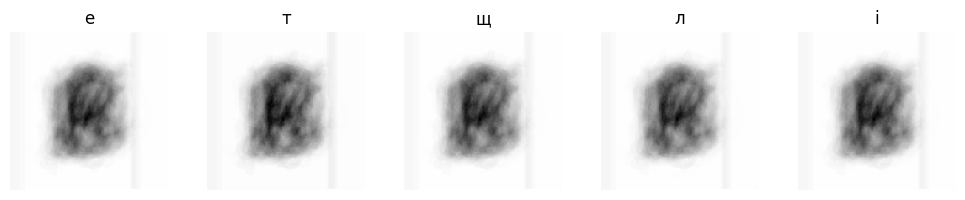

In [ ]:
visualize_generated_images_with_labels(generator, num_samples=5, num_classes=33, pca=pca, latent_dim=2)

In [ ]:
X_train_flattened = X_train_combined.reshape(-1, 128*128)
X_train_flattened.shape

(1980, 16384)

### **Conditional variational autoencoder with data in original dimentions (128x128)**

In [ ]:
# Model configuration
original_dim = 128*128
intermediate_dim = 1024
latent_dim = 2
num_classes = 33

# Inputs
inputs = Input(shape=(original_dim,))
labels = Input(shape=(num_classes,))

# Encoder
labels_encoded = Dense(intermediate_dim, activation='relu')(labels)
x = Concatenate()([inputs, labels_encoded])
x = Dense(intermediate_dim, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(intermediate_dim // 2, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization()(x)
z_mean = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
encoder = Model([inputs, labels], [z_mean, z_log_sigma, z], name='encoder')

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
decoder_labels = Input(shape=(num_classes,))
labels_encoded = Dense(intermediate_dim // 2, activation='relu')(decoder_labels)
decoder_input = Concatenate()([decoder_inputs, labels_encoded])
decoder_input = Concatenate()([decoder_inputs, decoder_labels])
x = Dense(intermediate_dim // 2, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(decoder_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(intermediate_dim, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization()(x)
x_decoded_mean = Dense(original_dim, activation='sigmoid')(x)
generator = Model([decoder_inputs, decoder_labels], x_decoded_mean, name='decoder')

# Instantiate VAE model
output_combined = generator([z, labels])
cvae = Model([inputs, labels], output_combined, name='cvae')

# Loss function
reconstruction_loss = binary_crossentropy(inputs, output_combined) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
cvae_loss = K.mean(reconstruction_loss + kl_loss)

cvae.add_loss(cvae_loss)

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
cvae.compile(optimizer=optimizer, loss=None)


In [ ]:
cvae.fit([X_train_flattened, y_train_onehot], epochs=10, batch_size=32)

1/1 [==============================] - 0s 161ms/step


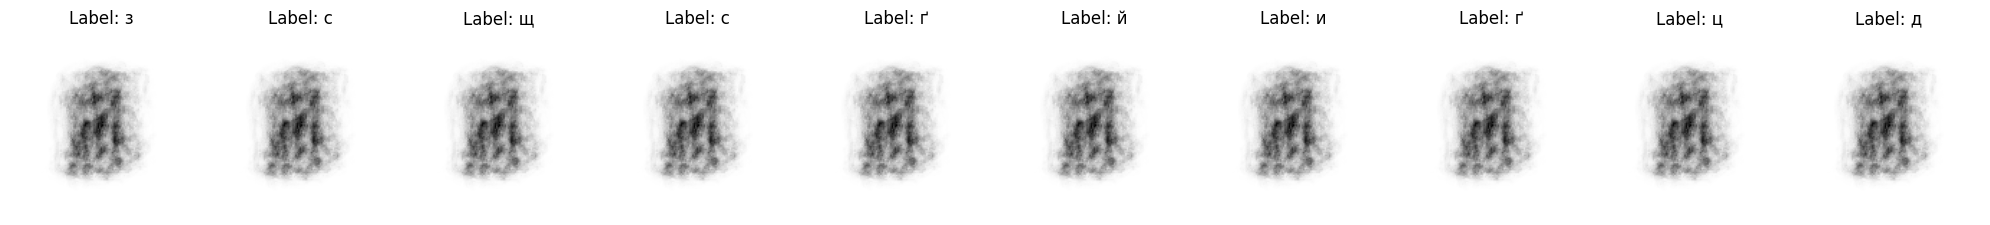

In [ ]:
def visualize_cvae_outputs(generator, num_samples, num_classes, latent_dim=2):
    # Generate random latent variables
    z_sample = np.random.normal(size=(num_samples, latent_dim))

    # Generate random labels (one-hot encoded)
    random_labels = np.random.randint(0, num_classes, size=num_samples)
    random_label_onehots = tf.keras.utils.to_categorical(random_labels, num_classes=num_classes)

    # Generate images using the decoder (generator)
    generated_images = generator.predict([z_sample, random_label_onehots])

    # Reshape images
    generated_images = generated_images.reshape(num_samples, 128, 128)

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap='gray')
        ax.set_title(f'Label: {index_to_label_mapping[random_labels[i]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_cvae_outputs(generator, num_samples=10, num_classes=33)


### **Variational autoencoder on original sized data on individual category**

In [ ]:
# Model configuration
original_dim = 128 * 128
intermediate_dim = 1024
latent_dim = 10

# Inputs
inputs = Input(shape=(original_dim,))

# Encoder
x = Dense(intermediate_dim, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(intermediate_dim // 2, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization()(x)
z_mean = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

# Sampling function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim // 2, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(decoder_inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(intermediate_dim, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization()(x)
x_decoded_mean = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(decoder_inputs, x_decoded_mean, name='decoder')

# Instantiate VAE model
output_combined = decoder(z)
vae = Model(inputs, output_combined, name='vae')

# Loss function
reconstruction_loss = binary_crossentropy(inputs, output_combined) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
vae.compile(optimizer=optimizer, loss=None)


In [ ]:
#training variational autoencoder only on 1 class
b = y_train_combined[10]
mask_b = (y_train_combined == b)
b_images = X_train_combined[mask_b]
b_images_flattened = b_images.reshape(b_images.shape[0], -1)

### **Output visualization with 10 epoch**

In [ ]:
vae.fit(b_images_flattened, epochs=10, batch_size=32)

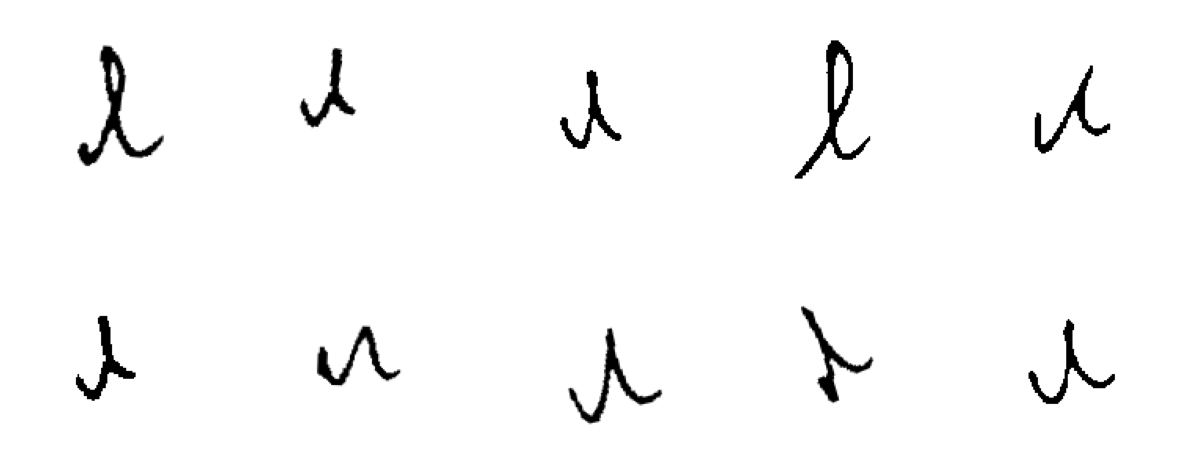

In [ ]:
# original images
def visualize_images(images, num_samples):
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

visualize_images(b_images, num_samples=10)

1/1 [==============================] - 0s 115ms/step


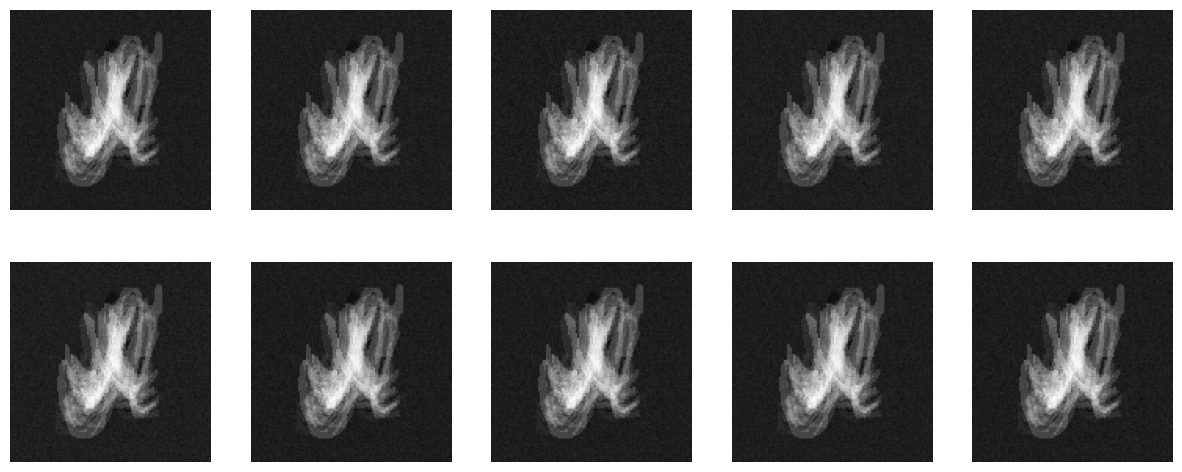

In [ ]:
def visualize_samples(decoder_model, num_samples, latent_dim):
    # Generate random latent vectors
    latent_vectors = np.random.normal(size=(num_samples, latent_dim))

    # Decode the latent vectors to generate samples
    decoded_images = decoder_model.predict(latent_vectors)

    # Reshape the decoded images
    decoded_images = decoded_images.reshape((-1, 128, 128))

    # Plot the decoded images
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(decoded_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

visualize_samples(decoder, num_samples=10, latent_dim = 10)


### **Output visualization with 100 epoch**

In [ ]:
#training variational autoencoder only on 1 class
c = y_train_combined[11]
mask_c = (y_train_combined == c)
c_images = X_train_combined[mask_c]
c_images_flattened = c_images.reshape(c_images.shape[0], -1)

In [ ]:
vae.fit(c_images_flattened, epochs=100, batch_size=32)

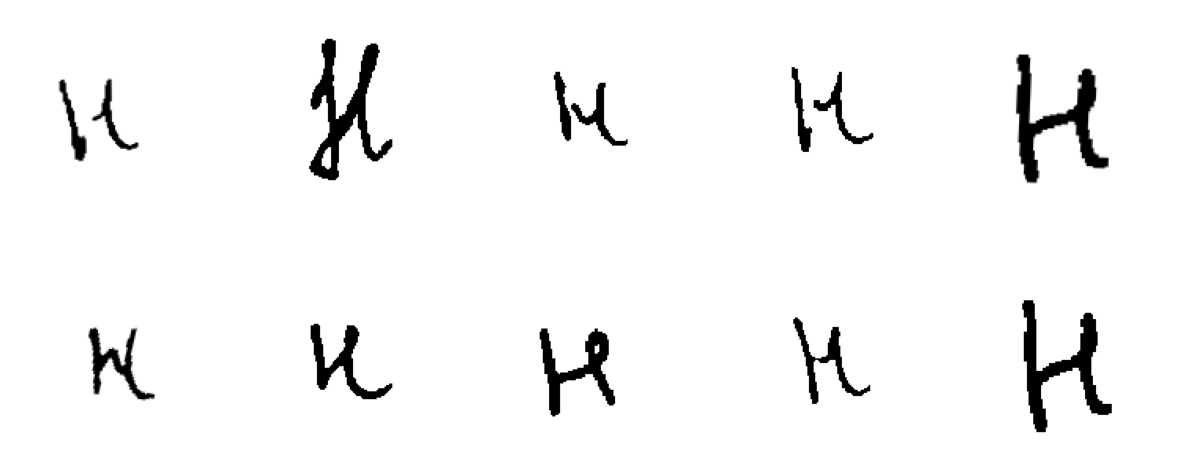

In [ ]:
visualize_images(c_images, num_samples=10)

1/1 [==============================] - 0s 21ms/step


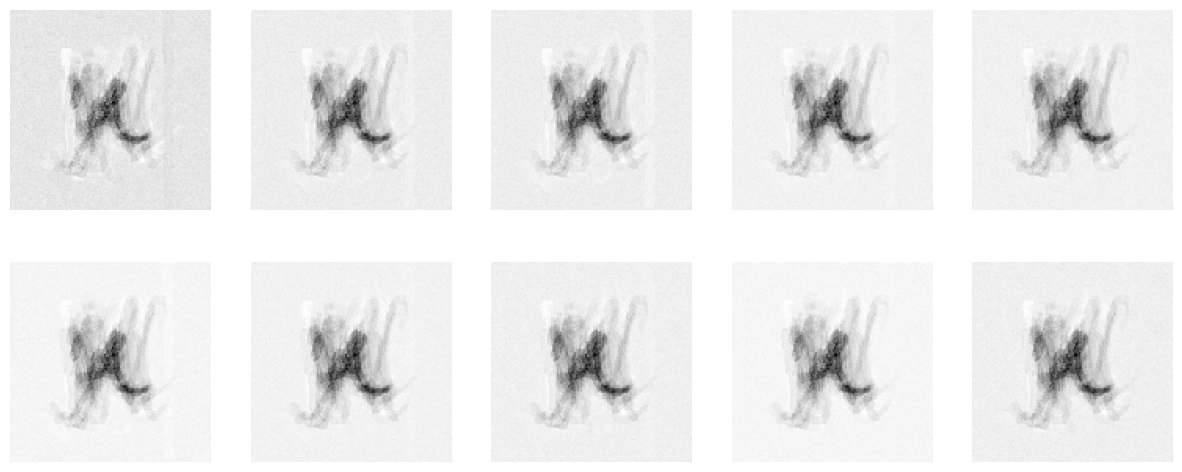

In [ ]:
visualize_samples(decoder, num_samples=10, latent_dim = 10)

### **Iterative VAE on all categories**

In [ ]:
def create_vae(input_dim):
    # Model configuration
    intermediate_dim = 1024
    latent_dim = 10

    # Encoder
    inputs = Input(shape=(input_dim,))
    x = Dense(intermediate_dim, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(intermediate_dim // 2, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
    x = BatchNormalization()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_sigma = Dense(latent_dim)(x)

    # Sampling function
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Decoder
    decoder_inputs = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim // 2, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(decoder_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(intermediate_dim, activation='relu', activity_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
    x = BatchNormalization()(x)
    x_decoded_mean = Dense(input_dim, activation='sigmoid')(x)
    decoder = Model(decoder_inputs, x_decoded_mean, name='decoder')

    # VAE model
    output_combined = decoder(z)
    vae = Model(inputs, output_combined, name='vae')

    # Loss function
    reconstruction_loss = binary_crossentropy(inputs, output_combined) * input_dim
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
    vae.compile(optimizer=optimizer, loss=None)

    return vae, encoder, decoder

# Train VAE for each category
def train_vae_for_categories(categories_flattened):
    vae_models = []
    for category_data in categories_flattened:
        vae, _, _ = create_vae(category_data.shape[1])
        vae.fit(category_data, epochs=10, batch_size=32, verbose=0)
        vae_models.append(vae)
    return vae_models

# Visualize original images and their reconstructions
def visualize_reconstructions(original_images, reconstructed_images):
    num_samples = min(len(original_images), len(reconstructed_images))
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_images[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(reconstructed_images[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
    plt.show()


In [ ]:
# separate dataset into categories
unique_ch = np.unique(y_train_combined)
categories = []
for ch in unique_ch:
    m = (y_train_combined == ch)
    img_category = X_train_combined[m]
    categories.append(img_category)
categories_flattened = [category.reshape(category.shape[0], -1) for category in categories]

In [ ]:
# Train VAE for each category
vae_models = train_vae_for_categories(categories_flattened)

In [ ]:
# Visualize reconstructions for each category
for i, vae_model in enumerate(vae_models):
    category_data = categories_flattened[i]
    sample_indices = np.random.randint(0, len(category_data), 2)
    original_images = category_data[sample_indices]
    reconstructed_images = vae_model.predict(original_images)
    visualize_reconstructions(original_images, reconstructed_images)

In [ ]:
def generate_samples_with_original_labels(vae_models, original_labels, num_samples_per_category=1000):
    generated_images = []
    generated_labels = []
    for i, vae_model in enumerate(vae_models):
        print(i)
        decoder_model = vae_model.get_layer('decoder')  # Access the decoder model
        category_samples = []
        for _ in range(num_samples_per_category):
            # Generate random latent vector
            latent_vector = np.random.normal(size=(1, latent_dim))
            # Decode latent vector to generate image
            generated_image = decoder_model.predict(latent_vector)
            category_samples.append(generated_image)
        generated_images.append(np.array(category_samples).reshape(-1, 128, 128))
        generated_labels.append(np.full(num_samples_per_category, original_labels[i]))  # Label each generated image with the corresponding original label
    return generated_images, generated_labels

In [ ]:
# Generate samples for each category with original labels
generated_images, generated_labels = generate_samples_with_original_labels(vae_models, unique_ch, num_samples_per_category=100)

# Convert generated images and labels to arrays
generated_images = np.concatenate(generated_images, axis=0)
generated_labels = np.concatenate(generated_labels, axis=0)


In [ ]:
generated_images = np.expand_dims(generated_images, axis=-1)

In [ ]:
# Concatenate generated samples with original data
X_train_combined_augmented = np.concatenate([X_train_combined, generated_images], axis=0)
y_train_combined_augmented = np.concatenate([y_train_combined, generated_labels], axis=0)

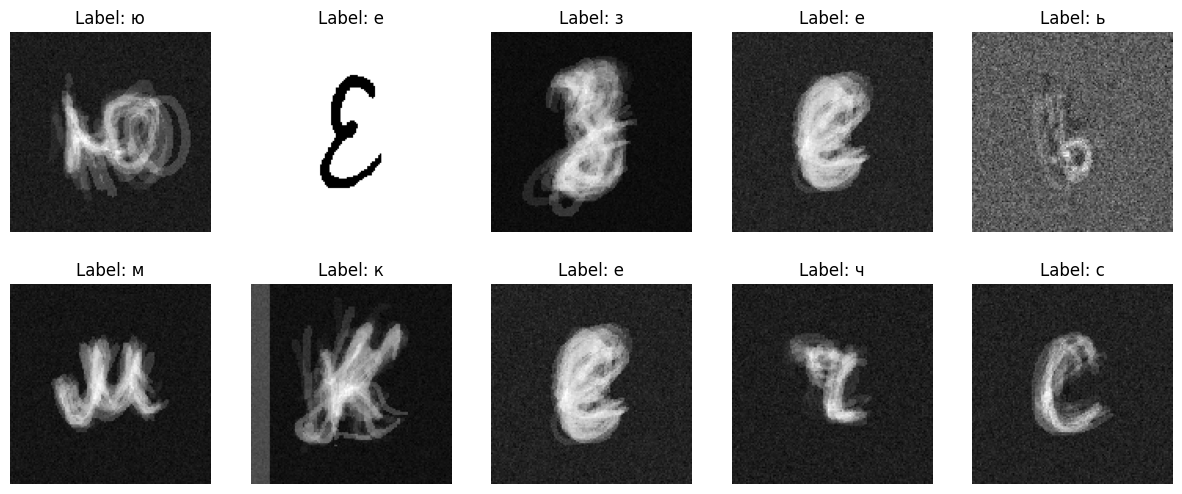

In [ ]:
import random

# Function to visualize random samples with corresponding labels
def visualize_random_samples_with_labels(samples, labels, num_samples=10):
    plt.figure(figsize=(15, 6))
    random_indices = random.sample(range(len(samples)), num_samples)
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(samples[idx], cmap='gray')
        plt.title("Label: {}".format(labels[idx]))
        plt.axis('off')
    plt.show()

# Visualize random samples with corresponding labels
visualize_random_samples_with_labels(X_train_combined_augmented, y_train_combined_augmented, num_samples=10)


### **Variateional autoencoders for each category on PCA preprocessed data**

In [ ]:
# separate dataset into categories
unique_ch = np.unique(y_train_combined)
categories = []
for ch in unique_ch:
    m = (y_train_combined == ch)
    img_category = X_train_pca[m]
    categories.append(img_category)
categories_flattened = [category.reshape(category.shape[0], -1) for category in categories]

In [ ]:
# Train VAE for each category
vae_models = train_vae_for_categories(categories_flattened)

In [ ]:
# Visualize reconstructions for each category
for i, vae_model in enumerate(vae_models):
    category_data = categories_flattened[i]
    sample_indices = np.random.randint(0, len(category_data), 2)
    original_images = category_data[sample_indices]
    reconstructed_images = vae_model.predict(original_images)

    # Inverse transform PCA-reduced images back to original dimensions
    original_images_original_dims = pca.inverse_transform(original_images)
    reconstructed_images_original_dims = pca.inverse_transform(reconstructed_images)

    visualize_reconstructions(original_images_original_dims, reconstructed_images_original_dims)


## **CNN on VAE augmented dataset**

I choose Convolutional Neural Network (CNN) model. CNNs are effective in processing grid-like data, like images. CNNs are good for tasks that require adaptive learning of hierarchies. They also work well for extracting features directly from images. The layered structure enables CNNs to learn patterns at different levels. For example, the initial layers can learn basic features like edges and curves,while deeper layers can recognize more complex shapes relevant to specific characters.

Thanks to shared weights and local connectivity in convolutional layers, CNNs require fewer parameters than fully connected networks of comparable size (for example Feed-Forward we were discussing in class). This sharing of weights in CNNs is what we refer to as a convolutional filter, which is slid across the entire image to detect specific features. This also makes CNNs less prone to overfitting, particularly useful when the dataset size is limited.


#### **Loss Function**

Given that the task is a multi-class classification, the loss function will be categorical cross-entropy, which compares the distribution of predictions with the true distribution of the labels. But before talking about the cross entrophy we have to talk about how and where we get the input for that function.

I use softmax function in the output layer to convert the raw logits (outputs of the last neural network layer) into probabilities by taking the exponential of each output and then normalizing these values by dividing by the sum of all the exponentials. This ensures that the output values are in the range (0, 1) and sum up to 1. The softmax function for a single class j is defined as:

$$
\hat{y}_j = \frac{e^{z_j}}{\sum_{k=1}^{C} e^{z_k}}
$$

Where:
- $\hat{y}_j$ is the predicted probability for class $j$.
- $z_j$ is the raw logit for class $j$.
- $C$ is the total number of classes.


The output of the softmax is nessesary for calculating categorical cross-entropy loss. For a single data point, the categorical cross-entropy loss can be mathematically defined as:

$$
L(y, \hat{y}) = -\sum_{j=1}^{C} y_j \log(\hat{y}_j)
$$

Where:
- $L$ is the loss for a single example.
- $C$ is the number of classes.
- $y$ is the true distribution of labels, represented as a one-hot encoded vector.
- $y_j$ is 1 for the correct class and 0 for all other classes.
- $\hat{y}$ is the predicted probability distribution over classes, output by the softmax function in the final layer of the model.
- $\hat{y}_j$ represents the predicted probability for class $j$.
- $\log$ is the natural logarithm.


The categorical cross-entropy loss for the entire dataset is the average of the individual losses over all $N$ data points:

$$
\text{Loss} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij})
$$

Where:
- $N$ is the number of data points in the dataset.
- $y_{ij}$ and $\hat{y}_{ij}$ correspond to the true label and predicted probability for class $j$ of the $i$-th data point, respectively.

Minimizing this loss function during training drives the predicted probabilities $\hat{y}_{ij}$ closer to the true labels $y_{ij}$ -> making the model's predictions more accurate.



### **Optimization Function**

I am choosing Adam optimizer over Stochastic gradient descent. Adam is short for Adaptive Moment Estimation (it was not developed by Adam). Adam is more complicated than SGD but is has a numebr of advantages. It adjusts the learning rate for each weight individually, based on the first and second moments of the gradients. This can lead to more effective training, especially for problems with sparse gradients or varying scales of data. It converges more quickly than SGD because of its adaptive learning rates and momentum-like behavior.

Adam is based on the combination of SGD with momentum (Adaptive Gradient Algorithm) and RMSProp (Root Mean Square Propagation) which is another "child" of SGD.

Adaptive gradient adapts the learning rates of all parameters by scaling them inversely proportional to the square root of the sum of all their historical squared gradients. Because of this it is able to give larger updates to infrequent parameters and smaller updates to frequent ones. It contributes to  a more stable learning process, reducing the risk of overshooting minima in the loss landscape.

RMSProp modifies learning rate for each weight based on the moving average of the squares of recent gradients for that weight. It reduces the magnitude of fluctuations in the updates of weights during training, so the optimization process becomes smoother, allowing the model to converge more steadily.

#### Okay, so how Adam works?

Adam maintains two moving averages for each weight in the network: one for gradients (like momentum) and one for squared gradients (like RMSProp):

**Moving Average of Gradients (First Moment Estimation):** This is similar to the momentum method, which helps to accelerate SGD in the relevant direction and dampens oscillations (reduces the magnitude of fluctuations). It calculates the exponentially weighted average of the gradients, using the parameter $ \beta_1 $ (usually set to ~ 0.9). The equation is:

   $$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) \nabla L(w_t) $$

where $ m_t $ is the first moment vector, $ \nabla L(w_t) $ is the gradient of the loss function with respect to the weights at time $ t $, and $ \beta_1 $ is the decay rate for the first moment estimates.

**Moving Average of Squared Gradients (Second Moment Estimation):** This keeps an exponentially weighted average of the squares of the gradients, using the parameter $ \beta_2 $ (commonly set around 0.999). This scales the learning rate inversely proportional to the square root of this average, which helps in adapting the learning rate for each weight. The equation is:

   $$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) (\nabla L(w_t))^2 $$

where $ v_t $ is the second moment vector.

Since $ m_t $ and $ v_t $ are initialized as vectors of 0's, they are biased towards zero, especially during the initial time steps, and especially when the decay rates are small ($ \beta_1 $ and $ \beta_2 $ are close to 1). Adam corrects these biases by computing bias-corrected first and second moment estimates:

   $$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t} $$
   $$ \hat{v}_t = \frac{v_t}{1 - \beta_2^t} $$

where $ t $ is the timestep.

Adam uses these bias-corrected estimates to update the weights, similar to how gradients are used in SGD, but with an adaptive learning rate based on the second moment estimate:

   $$ w_{t+1} = w_t - \frac{\eta \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $$

where $ \eta $ is the step size (learning rate), and $ \epsilon $ is a small scalar (e.g., $ 10^{-8} $) added to improve numerical stability.






In [ ]:
def create_cnn_model(input_shape, num_classes):
    """
    The model has 3 convolutinla layers with increasing number of fiters to detect more and more nuanced patterns
    each colnvolutional layer has a ReLU activation function and it followed by a pooling layer
    after a pooling layer the data gets transformed into a different input type to be processed by the dense layer
    we add the dropout layer to increase robustness
    there is 1 dense layer because we prioritize hierarhical learning
    the output layer with doftmax activation function gives the probabilities of the given image to belong to each of 65 categories

    Layers are added to the model sequentially (thus sequential model),
    the output of each layer becomes the input for the next layer in the sequence.
    """
    #initialize the model
    model = models.Sequential()

    #convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    #convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    #convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    #flatten the output
    model.add(layers.Flatten())

    #dropout for regularization
    model.add(layers.Dropout(0.5))

    #fully Connected Layer
    model.add(layers.Dense(128, activation='relu'))


    #output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

input_shape = (128, 128, 1)
num_classes = 33

cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
# Preprocess the images
X_train_combined_augmented = X_train_combined_augmented.reshape(-1, 128, 128, 1)  # Add channel dimension

# Convert labels to one-hot encoding
y_train_encoded = label_encoder.fit_transform(y_train_combined_augmented)
y_train_combined_augmented_onehot = to_categorical(y_train_encoded, num_classes)

# Train the CNN model
history = cnn_model.fit(X_train_combined_augmented, y_train_combined_augmented_onehot,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.2)  # Split data into training and validation sets


In [ ]:
# Preprocess the test set
X_test = np.array(X_test)
X_test = X_test.reshape(-1, 128, 128, 1)

# Convert labels to one-hot encoding
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_onehot)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 0s 26ms/step - loss: 6.3999 - accuracy: 0.0516
Test Loss: 6.399876594543457
Test Accuracy: 0.051643192768096924


In [ ]:
# Predict labels for the test set
y_pred = cnn_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

y_test_numeric = label_encoder.fit_transform(y_test)

# Compute metrics
f1 = f1_score(y_test_numeric, y_pred_labels, average='weighted')
precision = precision_score(y_test_numeric, y_pred_labels, average='weighted')
recall = recall_score(y_test_numeric, y_pred_labels, average='weighted')


print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


7/7 [==============================] - 0s 2ms/step
F1 Score: 0.005072099262240107
Precision: 0.002667019330379775
Recall: 0.051643192488262914


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the results above we can see that the model slthought improved by 150% from the previous assignment, still has an accuracy only slighly better than the guess. The reason for that might be that even thought the images generated by VAE is good for human eye the model does not recognise it.

## **GANs**

As a new step I will try another approach to synthethic data generation.
GAN is a generative model that learns to generate data samples that are similar to a dataset. The GAN consists of two main components: a generator and a discriminator. The generator learns to generate realistic data samples, while the discriminator learns to distinguish between real data samples from the dataset and fake data samples generated by the generator.

## Model Architecture

### Generator

The generator network **G** takes random noise **z** sampled from a prior distribution as input and maps it to the data space. Mathematically, the generator can be represented as:

$$
G:z \rightarrow x
$$

where **z** is a random noise vector sampled from a prior distribution and **x** is the generated data sample. The generator consists of a series of layers, including dense layers and transposed convolutional layers, which transform the input noise into a synthetic data sample.

### Discriminator

The discriminator network **D** takes a data sample as input and outputs a probability score indicating whether the input sample is real or fake. Mathematically, the discriminator can be represented as:

$$
D:x \rightarrow [0,1]
$$

where **x** is the input data sample and **[0,1]** represents the probability that the input sample is real. The discriminator consists of convolutional layers followed by fully connected layers, which process the input data sample and output a probability score.

## Training

### Adversarial Training

During training, the generator and discriminator are trained in an adversarial manner. The generator aims to minimize the discrepancy between the distribution of generated data and real data, while the discriminator aims to distinguish between real and fake data.

### Minimax Game

The training objective of GANs can be formulated as a minimax game between the generator and discriminator. The generator tries to minimize the following objective function:

$$
\min_G \max_D V(D,G) = E_{x\sim p_{data}(x)}[\log D(x)] + E_{z\sim p_z(z)}[\log(1-D(G(z)))]
$$

where:
- $( p_{data}(x))$ is the distribution of real data samples,
- $( p_z(z) )$ is the prior distribution of noise,
- $( D(x) )$ is the discriminator's output probability for real data,
- $( G(z) )$ is the generator's output given noise $( z )$,
- $( E )$ denotes the expectation over the respective distributions.


### Hyperparameters and Optimization

- **Batch Size**: The number of samples processed in each training iteration.
- **Noise Dimension**: The dimensionality of the random noise vector input to the generator.
- **Learning Rate**: The rate at which the optimizer updates the parameters during training. A small learning rate is chosen to prevent drastic parameter updates.
- **Clipnorm**: The maximum gradient norm allowed during training. Gradient clipping helps prevent exploding gradients and stabilizes training.


## Pseudo Algorithm

1. **Initialization**: Initialize the generator $ G $ and discriminator $ D $ with random weights.

2. **Define Generator Loss**:
   - Define the generator loss function $ L_G $:
   
     $ L_G = -E[D(G(z))] $
   where:
     - $ G(z) $ is the generated sample from random noise $ z $.
     - $ D(G(z)) $ is the discriminator's output on the generated sample.

3. **Define Discriminator Loss**:
   - Define the discriminator loss function $ L_D $:

    $$ L_D = E[D(x)] - E[D(G(z))] $$
   where:
     - $ x $ is a real sample from the dataset.
     - $ D(x) $ is the discriminator's output on the real sample.
     - $ G(z) $ is the generated sample from random noise $ z $.
     - $ D(G(z)) $ is the discriminator's output on the generated sample.

4. **Define WGAN-GP Loss**:
   - Define the WGAN-GP loss function $ L_{GP} $:

 $$ L_{GP} = \lambda \cdot E[(|\nabla D(\tilde{x})|_2 - 1)^2] $$
   where:
     - $ \tilde{x} $ is a random convex combination of real and generated samples.
     - $ \lambda $ is the gradient penalty coefficient.

5. **Total Discriminator Loss**:
   - Define the total discriminator loss as the sum of the Wasserstein loss and the gradient penalty:
     $ L_{D_{total}} = L_D + L_{GP} $

6. **Optimization Objective**:
   - Define the optimization objective:
     $ \min_G \max_D L_{D_{total}} $

7. **Training Loop**:
   - For each epoch do:
     - For each mini-batch of real samples $ x $ do:
       - Sample random noise $ z $ from a normal distribution.
       - Update the discriminator $ D $ using gradient ascent:
         $ \nabla_{D} L_{D_{total}} = \nabla_{D} (L_D + L_{GP}) $
         $ D \leftarrow D + \alpha \cdot \nabla_{D} L_{D_{total}} $
         - Clip the weights of $ D $ to enforce Lipschitz constraint.

     - Sample random noise $ z $ from a normal distribution.
     - Update the generator $ G $ using gradient descent:
       $ \nabla_{G} L_G = -\nabla_{G} D(G(z)) $
       $ G \leftarrow G - \alpha \cdot \nabla_{G} L_G $

8. **Post-training**:
   - After training, the generator $ G $ can be used to generate new samples from random noise $ z $.




In [ ]:
b = y_train_combined[2]
mask_b = (y_train_combined == b)
b_images = X_train_combined[mask_b]
b_images_normalized = (b_images * 2) - 1  # Normalize the images to [-1, 1]

In [ ]:
def make_generator_model():
    model = keras.Sequential()

    # Initial dense layer
    model.add(Dense(8 * 8 * 512, input_shape=(NOISE_DIM,)))
    model.add(Reshape((8, 8, 512)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 16x16
    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 32x32
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 64x64
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 128x128
    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Final convolutional layer
    model.add(Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='tanh'))

    return model

In [ ]:
def make_discriminator_model():
    model = keras.Sequential()

    # Downsampling to 64x64
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Downsampling to 32x32
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Downsampling to 16x16
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Downsampling to 8x8
    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Output layer
    model.add(Flatten())
    model.add(Dense(1))  # No activation here since we use from_logits=True in the loss

    return model

In [ ]:

# Training loop
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      print('gen_loss', gen_loss)
      print('disc_loss', disc_loss)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
      print(epoch)
      for image_batch in dataset:
          train_step(image_batch)


In [ ]:

# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = tf.reshape(predictions, (-1, 128, 128))  # Reshape to [batch_size, 218, 128]

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2, cmap='gray')
        plt.axis('off')

    #plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = tf.reshape(predictions, (-1, 128, 128))  # Reshape to [batch_size, 128, 128]

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i] * 0.5 + 0.5, cmap='gray')  # Denormalize the image
        plt.axis('off')

    plt.show()

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
NOISE_DIM = 400

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001, clipnorm=1.0)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001, clipnorm = 1.0)

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(b_images_normalized).batch(BATCH_SIZE)

EPOCHS = 50

# Train the GAN
train(train_dataset, EPOCHS)


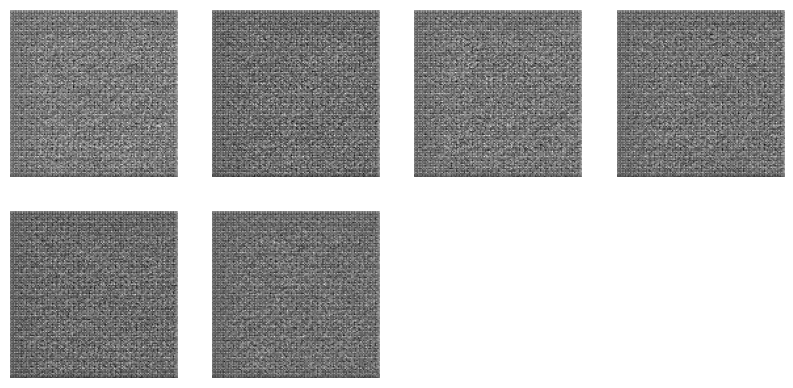

In [ ]:
# Generate some test noise samples
test_input = tf.random.normal([6, NOISE_DIM])
generate_and_save_images(generator, EPOCHS, test_input)

As we can see on the visuzlization the model was not able to reproduce the realistic samples.
Initially the problem was in model colapse: discriminator was much better than generator.

To combat this I increased the ecomplexity of generator by ading additionla layers. It helped to balance the G loss and the D loss but still the model was converging too fast and was not learning the patterns.

I decreased learning rate to make convergence more gradual.

I set a clip value to limit the magnitude of gradients during backpropagation.

I added batch normalization after each layer in both the generator and discriminator to stabilize the training process by normalizing the activations -> model is less sensitive to initialization.

I used Leaky ReLU  with a small negative slope (alpha=0.2) in both the generator and discriminator instread of ReLU. Leaky ReLU prevents the issue of "dying ReLU" by allowing small negative gradients, which can be crucial for training deep neural networks effectively.

I experimented with different numbers of hyperparameters to fins=d the best set, number of training epoch (up to 100), size of the noise dimension  (from 10 to 500). Despote all the modifications, the model still does not output the sensible results which can be due to the limit of the training data. To address this, additional data gathering process shouls be performed.

### **Conclusion and next steps**


We saw how adding only 1000 more datapoints can change significantly the quality of the output of the autoencoder. However, it still did not help to train a robust cnn model. Similarly, for the GAN model the dataset was too smal. To combat that I want to source more data in a form of handwritten samples of text and extract charactes from there.
Another idea that I want to pursue is to train the GAN on the output from the VAE.